In [25]:
import argparse
import os
import os.path as osp
import sys
from glob import glob

import cv2
import numpy as np
import torch
import torch.nn.functional as F
from torch.utils.data import DataLoader, Dataset
from tqdm import tqdm

os.chdir("/home/017534556/projects/cmpe_297/object_tracker")

In [26]:
import flow_vis as fv
import lovely_numpy as ln
import lovely_tensors as lt
import matplotlib.pyplot as plt

from agflow_main.core.raft_agflow import AGFlow
from agflow_main.core.utils import flow_viz, frame_utils
from agflow_main.core.utils.augmentor import FlowAugmentor, SparseFlowAugmentor

torch.set_grad_enabled(False)
sys.path.append("/home/017534556/projects/cmpe_297/object_tracker/agflow_main")

In [27]:
args = {
    "model": "/scratch/cmpe297-sp24/agflow/weights/agflow-sintel.pth",
    "dataset": "kitti",
    "mixed_precision": True,
}
args = argparse.Namespace(**args)

In [28]:
model = torch.nn.DataParallel(AGFlow(args))
model.load_state_dict(torch.load(args.model))
model = model.eval()
model = model.cuda()

=== Model: AGFlow ===


In [30]:
class Video:
    def __init__(self, video_path, target_fps=None):
        self.video_path = video_path
        self.target_fps = target_fps

        self.input_frames_folder = "/home/017534556/projects/cmpe_297/object_tracker/notebooks/temp_frames/input_frames"
        self.output_frames_folder = "/home/017534556/projects/cmpe_297/object_tracker/notebooks/temp_frames/output_frames"

        os.makedirs(self.output_frames_folder, exist_ok=True)
        os.makedirs(self.input_frames_folder, exist_ok=True)
        self.reset()

        self.video_to_images(self.video_path, mode="input")

    def delete_files_in_folder(self, folder):
        for f in os.listdir(folder):
            os.remove(os.path.join(folder, f))

    def reset(self):
        self.delete_files_in_folder(self.input_frames_folder)
        self.delete_files_in_folder(self.output_frames_folder)

    def create_output_video(self):
        assert (
            len(os.listdir(self.output_frames_folder)) > 0
        ), "No output frames found, run the model and save the output frames to convert to model"
        self.output_video_location = "/home/017534556/projects/cmpe_297/object_tracker/notebooks/videos/output_video.mp4"
        self.images_to_video(
            self.output_frames_folder,
            self.output_video_location,
        )
        return f"Output video created successfully at {self.output_video_location}"

    def create_input_video(self):
        assert len(os.listdir(self.input_frames_folder)) > 0, "No input frames found"
        self.input_video_location = "/home/017534556/projects/cmpe_297/object_tracker/notebooks/videos/input_video.mp4"
        self.images_to_video(
            self.input_frames_folder,
            self.input_video_location,
        )
        return f"Input video created successfully at {self.input_video_location}"

    def video_to_images(self, video_path, mode):
        # Create the output folder if it doesn't exist
        output_folder = f"/home/017534556/projects/cmpe_297/object_tracker/notebooks/temp_frames/{mode}_frames"

        # Open the video file
        cap = cv2.VideoCapture(video_path)
        success, image = cap.read()
        count = 0

        frame_rate = cap.get(cv2.CAP_PROP_FPS)
        self.fps = frame_rate
        if self.target_fps is not None:
            frame_skip = int(round(frame_rate / self.target_fps))
        else:
            frame_skip = 1

        # Loop through the video frames
        while success:
            # Save the frame as a JPEG image
            if count % frame_skip == 0:
                frame_path = os.path.join(output_folder, f"frame_{count:04d}.jpg")
                cv2.imwrite(frame_path, image)

            # Read the next frame
            success, image = cap.read()
            count += 1

        cap.release()

    def images_to_video(self, folder, output_path):
        # Get the list of image files
        files = glob(osp.join(folder, "*.png"))
        if len(files) == 0:
            files = glob(osp.join(folder, "*.jpg"))

        # Open the first image and get the dimensions
        image = cv2.imread(files[0])
        height, width, layers = image.shape

        # Create a video writer
        fourcc = cv2.VideoWriter_fourcc(*"mp4v")
        out = cv2.VideoWriter(output_path, fourcc, self.fps, (width, height))

        # Write the images to the video
        for file in files:
            image = cv2.imread(file)
            out.write(image)

        out.release()


v = Video(
    video_path="/home/017534556/projects/cmpe_297/object_tracker/test_1_crop.mp4"
)

In [38]:
class AnyDataset(Dataset):
    def __init__(self, aug_params=None, sparse=True, root=None):
        self.augmentor = None
        self.sparse = sparse
        self.split = "testing"
        self.is_test = True
        if aug_params is not None:
            if sparse:
                self.augmentor = SparseFlowAugmentor(**aug_params)
            else:
                self.augmentor = FlowAugmentor(**aug_params)

        self.is_test = False
        self.init_seed = False
        self.flow_list = []
        self.image_list = []
        self.extra_info = []

        assert (
            root is not None
        ), "Specify a directory which has png files derived from video"

        all_images = sorted(glob(osp.join(root, "*.jpg")))

        images1 = all_images[:-1]
        images2 = all_images[1:]

        for idx, (i1, i2) in enumerate(zip(images1, images2)):
            self.extra_info += [[idx]]
            self.image_list += [[i1, i2]]

    def __len__(self):
        return len(self.image_list)

    def __getitem__(self, index):
        img1 = frame_utils.read_gen(self.image_list[index][0])
        img2 = frame_utils.read_gen(self.image_list[index][1])

        img1 = np.array(img1).astype(np.uint8)[..., :3]
        img2 = np.array(img2).astype(np.uint8)[..., :3]

        img1 = torch.from_numpy(img1).permute(2, 0, 1).float()
        img2 = torch.from_numpy(img2).permute(2, 0, 1).float()
        return img1, img2, self.extra_info[index]

In [32]:
inference_dataloader = DataLoader(
    AnyDataset(root=v.input_frames_folder),
    batch_size=1,
    shuffle=False,
    num_workers=1,
    pin_memory=False,
)
len(inference_dataloader)

386

In [33]:
class InputPadder:
    """Pads images such that dimensions are divisible by 8"""

    def __init__(self, dims, mode="sintel"):
        self.ht, self.wd = dims[-2:]
        pad_ht = (((self.ht // 8) + 1) * 8 - self.ht) % 8
        pad_wd = (((self.wd // 8) + 1) * 8 - self.wd) % 8
        if mode == "sintel":
            self._pad = [
                pad_wd // 2,
                pad_wd - pad_wd // 2,
                pad_ht // 2,
                pad_ht - pad_ht // 2,
            ]
        else:
            self._pad = [pad_wd // 2, pad_wd - pad_wd // 2, 0, pad_ht]

    def pad(self, *inputs):
        return [F.pad(x, self._pad, mode="replicate") for x in inputs]

    def unpad(self, x):
        ht, wd = x.shape[-2:]
        c = [self._pad[2], ht - self._pad[3], self._pad[0], wd - self._pad[1]]
        return x[..., c[0] : c[1], c[2] : c[3]]

Best 128 -> anything above is useless

In [34]:
iterations_to_run_raft = 24
flows = []
for idx, (img1, img2, extra_info) in tqdm(
    enumerate(inference_dataloader), total=len(inference_dataloader)
):
    frame_id = str(extra_info[0].item())
    padder = InputPadder(img1.shape, mode="kitti")
    img1, img2 = padder.pad(img1.cuda(), img2.cuda())
    _, flow_pr = model(img1, img2, iters=iterations_to_run_raft, test_mode=True)
    flow = padder.unpad(flow_pr[0]).permute(1, 2, 0).detach().cpu().numpy()
    flows.append(flow)
    output_filename = os.path.join(v.output_frames_folder, frame_id) + ".jpg"
    # write flow to disk wha
    flow_image = flow_viz.flow_to_image(flow)
    plt.imsave(output_filename, flow_image)

100%|██████████| 386/386 [02:02<00:00,  3.16it/s]


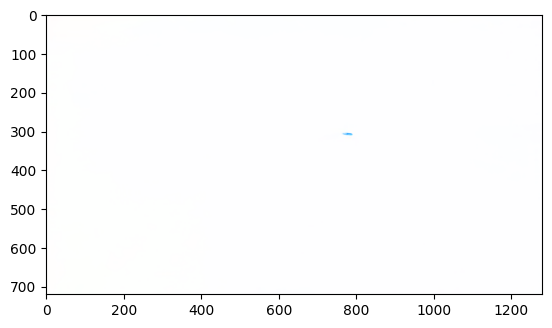

In [41]:
flow_color = fv.flow_to_color(flows[60])
plt.imshow(flow_color)

In [36]:
v.create_output_video()

'Output video created successfully at /home/017534556/projects/cmpe_297/object_tracker/notebooks/videos/output_video.mp4'

In [37]:
v.create_input_video()

'Input video created successfully at /home/017534556/projects/cmpe_297/object_tracker/notebooks/videos/input_video.mp4'

- Try putting a threshold for flow to be considered
- Try background subtraction